# An AI Tool for Image Supersampling using tensorflow and Keras
## 963906 - Alex Jones
Importing of functions from other ipynb files didn't work, so now I move everything into one notebook

##### Running necessary imports for whole file
**Imports for Architecture**

In [1]:
from keras.layers import Dense, Input
from keras.layers.core import Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers import Add
import os

**Imports for training**

In [38]:
import matplotlib as plt
from keras.applications.vgg19 import VGG19
from keras.layers.convolutional import UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing import image_dataset_from_directory as image_data_dir
import keras
import keras.backend as K
from keras.layers import Input
import tensorflow as tf
from skimage import data, io
import skimage.transform
from skimage.transform import rescale, resize
from scipy.ndimage import rotate
import numpy as np
from numpy import array, asarray
from numpy import random as nprand
import os, random
from natsort import natsorted, ns
from PIL import Image

##### Configuration of variables

In [39]:
from easydict import EasyDict as edict
from datetime import datetime

today = datetime.now()

In [40]:
config = edict()
config.TRAIN = edict()

In [41]:
## Adam optimizer settings
config.TRAIN.batch_size = 1

# initialise GAN
config.TRAIN.epochs = 50
config.TRAIN.residual = 16

# images
#config.TRAIN.hr_images = '../BSR/BSDS500/data/images'

##### Uncomment based on which dataset to test on
# config.TRAIN.hr_images = '../Berries'
# config.TRAIN.hr_images = '../Birds'
# config.TRAIN.hr_images = '../Dogs'
# config.TRAIN.hr_images = '../Flowers'
# config.TRAIN.hr_images = '../Linnaeus256'
config.TRAIN.hr_images = '../Linnaeus1000'
# config.TRAIN.hr_images = '../40Flowers'
config.TRAIN.training_img = config.TRAIN.hr_images + '/train'
config.TRAIN.testing_img = config.TRAIN.hr_images + '/test'
config.TRAIN.output_img = './output'

#Time folder

#### Creating the output folders, first organised by data
todayStr = today.strftime("test-%m-%d")
print(todayStr)
date = './output/' + todayStr
if not os.path.exists(date):
    os.makedirs(date)
    
#### Now organised by data used and the hour of testing in the day
nowStr = today.strftime("/%Hth_hour")
fullFolder = date +  nowStr
if not os.path.exists(fullFolder):
    os.makedirs(fullFolder)
print(nowStr)


config.TRAIN.output_today_now = (fullFolder)
#config.TRAIN.validation = config.TRAIN.hr_images + '/val'
config.TRAIN.downscale = 4
config.TRAIN.image_shape = (256,256,3)
config.TRAIN.lr_init = 1e-4
config.TRAIN.beta1 = 0.9
config.TRAIN.beta2 = 0.999
config.TRAIN.epsilon = 1e-08
config.TRAIN.filters = 64
config.TRAIN.kernel = 3
config.TRAIN.stride = 1

test-04-12
/14th_hour


##### Architectural setup

In [42]:
dir_path = os.path.dirname(os.path.realpath("config.ipynb"))

print(config.TRAIN.batch_size)

1


Defining blocks for the generator as descibed in architecture set out in: 
- https://arxiv.org/pdf/1609.04802.pdf

In [43]:
def residual(model, filters, kernel_filter, stride):
    
    res = Conv2D(filters = filters, kernel_size = kernel_filter, strides = stride, padding = "same")(model)
    # At the end convolved with the model to produce an output of tensors
    res = BatchNormalization(momentum = 0.5)(res)
    # momentum is momentum of moving averages
    
    res = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(res)
    # As defined in https://keras.io/api/layers/activation_layers/prelu/
    res = Conv2D(filters = filters, kernel_size = kernel_filter, strides = stride, padding = "same")(res)
    res = BatchNormalization(momentum = 0.5)(res)
    
    res = Add()([res,model])
    # add original model passed in with new block defined
    
    return res

In [44]:
def pixel_shuffling(model, filters, kernel_size, stride):
    
    # 2 x PixelShuffler
    upsample = UpSampling2D(size = 2)(model)
    upsample = Conv2D(filters = filters, kernel_size = kernel_size, strides = stride, padding = "same")(upsample)
    # alpha defaults to 0.3 so left as is
#     upsample = LeakyReLU(alpha = 0.2)(upsample)
    upsample = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(upsample)
    
    return upsample

In [45]:
def pixelshuffle_block(model, filters, kernels, stride):
    #up_sampling_block(generator_model, 256, (3,3) , (1,1))
    # 2 x PixelShuffler
    model = UpSampling2D(size = 2)(model)
    model = Conv2D(filters = filters, kernel_size = kernels, strides = stride, padding = "same")(model)
    # alpha defaults to 0.3 so left as is
    model = LeakyReLU(alpha = 0.2)(model)
    return model

In [46]:
def resUpSample(model, filters, kernel_filter, stride):  
    modelTmp = model
    for i in range(16):
        modelState = model
        model = Conv2D(filters = filters, kernel_size = kernel_filter, strides = stride, padding = "same")(model)
        # At the end convolved with the model to produce an output of tensors
        model = BatchNormalization(momentum = 0.5)(model)
        # momentum is momentum of moving averages

        model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
        # As defined in https://keras.io/api/layers/activation_layers/prelu/
        model = Conv2D(filters = filters, kernel_size = kernel_filter, strides = stride, padding = "same")(model)
        model = BatchNormalization(momentum = 0.5)(model)

        model = Add()([modelState,model])
        # add original model passed in with new block defined
    model = Conv2D(filters=config.TRAIN.filters, kernel_size=config.TRAIN.kernel, strides=config.TRAIN.stride, padding = "SAME")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    model = Add()([modelTmp, model])
    
    for i in range(2):
        model = Conv2D(filters = config.TRAIN.filters*4, kernel_size = config.TRAIN.kernel, strides = config.TRAIN.stride, padding = "same")(model)
        # 2 x PixelShuffler
        model = UpSampling2D(size = 2)(model)
        # alpha defaults to 0.3 so left as is
        model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
        
    return model

In [47]:
# Network architecture simplified from paper https://arxiv.org/pdf/1609.04802.pdf
def GenNet(img_shape):
    generator_input = Input(shape = img_shape)
    # Bracket at the end defines input and first dimension of tensor, because this is non-sequential model
    generator_model = Conv2D(filters = config.TRAIN.filters, kernel_size = 9, strides = config.TRAIN.stride, padding="SAME")(generator_input)
    generator_model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(generator_model)

    #generator_model.summary()
    modelTmp = generator_model

    # Start simple using 8 residual blocks
    for i in range(config.TRAIN.residual):
        generator_model = residual(generator_model, config.TRAIN.filters, config.TRAIN.kernel, config.TRAIN.stride)

    generator_model = Conv2D(filters=config.TRAIN.filters, kernel_size=config.TRAIN.kernel, strides=config.TRAIN.stride, padding = "SAME")(generator_model)
    generator_model = BatchNormalization(momentum = 0.5)(generator_model)
    generator_model = Add()([modelTmp, generator_model])


    # 2 UpSampling of PixelShuffling Blocks
    for i in range(2):
        generator_model = pixel_shuffling(generator_model, config.TRAIN.filters*4,config.TRAIN.kernel,config.TRAIN.stride)

#     generator_model = resUpSample(generator_model, config.TRAIN.filters, config.TRAIN.kernel, config.TRAIN.stride)

    generator_model = Conv2D(filters = 3, kernel_size = 9, strides = config.TRAIN.stride, padding="SAME")(generator_model)
    generator_model = Activation('tanh')(generator_model)

    generator_model_complete = Model(inputs = generator_input, outputs = generator_model, name = "Generator")


    print("This is the model summary for the Generator: ")
    print(generator_model_complete.summary())
    return generator_model_complete


In [48]:
def discriminator_block(model, filters, kernel_size, strides):
    
    discriminator_b = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = "same")(model)
    discriminator_b = BatchNormalization(momentum = 0.5)(discriminator_b)
    discriminator_b = LeakyReLU(alpha = 0.2)(discriminator_b)
    
    return discriminator_b

In [49]:
# Network architecture simplified from paper stated above
def DisNet(img_shape):

    disc_0 = Input(shape = img_shape)

    disc_1 = Conv2D(config.TRAIN.filters, (3,3), 1, padding="SAME")(disc_0)
    disc_1 = LeakyReLU(alpha=0.2)(disc_1)

    disc_2 = discriminator_block(disc_1, config.TRAIN.filters, 3, 2)
    disc_3 = discriminator_block(disc_2, config.TRAIN.filters*2, 3, 1)
    disc_4 = discriminator_block(disc_3, config.TRAIN.filters*2, 3, 2)
    disc_5 = discriminator_block(disc_4, config.TRAIN.filters*4, 3, 1)
    disc_6 = discriminator_block(disc_5, config.TRAIN.filters*4, 3, 2)
    disc_7 = discriminator_block(disc_6, config.TRAIN.filters*8, 3, 1)
    disc_8 = discriminator_block(disc_7, config.TRAIN.filters*8, 3, 2)

    disc_8 = Flatten()(disc_8)
    disc_9 = Dense(1024)(disc_8)
    disc_10 = LeakyReLU(alpha=0.2)(disc_9)

    valid = Dense(1)(disc_10)
    valid = Activation('sigmoid')(valid)

    complete_model = Model(inputs = disc_0, outputs = valid, name = "Discriminator")


    print("This is the model summary for the discriminator: ")
    print(complete_model.summary())
    return complete_model



##### Setting up training of the GAN

In [50]:
# Allows reproducibility of results
np.random.seed(7)
print(config.TRAIN)
image_shape = (config.TRAIN.image_shape)
print(image_shape)

{'batch_size': 1, 'epochs': 50, 'residual': 16, 'hr_images': '../Linnaeus1000', 'training_img': '../Linnaeus1000/train', 'testing_img': '../Linnaeus1000/test', 'output_img': './output', 'output_today_now': './output/test-04-12/14th_hour', 'downscale': 4, 'image_shape': [256, 256, 3], 'lr_init': 0.0001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08, 'filters': 64, 'kernel': 3, 'stride': 1}
[256, 256, 3]


In [51]:
def vgg_loss(y_true, y_pred):
    vgg19 = VGG19(include_top=False, weights="imagenet", input_shape=config.TRAIN.image_shape)
    vgg19.trainable = False
    vgg19_outputs = vgg19.get_layer('block5_conv4').output
    for layer in vgg19.layers:
        layer.trainable = False
    loss_model = Model(inputs=vgg19.input, outputs=vgg19_outputs)
    loss_model.trainable = False
    return K.mean(K.square(loss_model(y_true) - loss_model(y_pred)))

In [16]:
def make_gan(d, image_shape, g, optimizer):
    d.trainable = False
    gan_input = Input(shape=image_shape)
    network = g(gan_input)
    gan_output = d(network)
    gan = Model(inputs=gan_input, outputs=[network,gan_output], name = "GAN")
    gan.compile(loss=[vgg_loss, "binary_crossentropy"],
                loss_weights=[1., config.TRAIN.lr_init],
                optimizer=optimizer)
    
    print("This is the model summary for the generative adversarial network: ")
    print(gan.summary())

    return gan

Getting dataset from local files

In [17]:
# dir_path = os.path.dirname(os.path.abspath("C:/Users/ajwil/Documents/Bsc Dissertation/FinalProject"))
# print(dir_path)
# root_dir = os.path.abspath("C:/Users/ajwil/Documents/Bsc Dissertation/FinalProject/BSR/BSDS500/data")
# print(root_dir)

C:\Users\ajwil\Documents\Bsc Dissertation
C:\Users\ajwil\Documents\Bsc Dissertation\FinalProject\BSR\BSDS500\data


In [18]:
image_crop_dimensions = config.TRAIN.image_shape[0]
downscale_factor = config.TRAIN.downscale
downscaled_size = image_crop_dimensions // downscale_factor
batch_size = 5

print(image_crop_dimensions)
print("Downscale factor: ", downscale_factor)
print(downscaled_size)

256
Downscale factor:  4
64


Functions for load_path(path), load_data_from_folder(folder,extension), and load_data(directory,extension)

In [19]:
def load_path(path):
    directory = []
    if os.path.isdir(path):
        print("Directory: ", path, " is a real directory!")
        directory.append(path)
    for elem in os.listdir(path):
        if os.path.isdir(os.path.join(path,elem)):
            directory = directory + load_path(os.path.join(path,elem))
            directory.append(os.path.join(path,elem))
    return directory
    
def load_data_from_folder(folder, ext):
    files = []
    file_names = []
    for img in folder:
        for f in os.listdir(img): 
            if f.endswith(ext):
                image = io.imread(os.path.join(img,f))
                # All images in dataset were either (321,481,3) or (481,321,3) for the purpose of the generator they all had to be same size 
                if (image.shape[0] > image.shape[1]):
                    image = rotate(image, angle=90.0)
                if len(image.shape) > 2:
                    files.append(image)
                    file_names.append(os.path.join(img,f))
                    
    print(" with: ", len(files), " elements!")
    return files

In [20]:
def load_data(directory, ext):

    files = load_data_from_folder(load_path(directory), ext)
    
    rand_check = random.randint(0, len(files)-1)
    print("Random num check of image", rand_check, "has shape: ")
    print(files[rand_check].shape)
    return files

In [21]:
x_train = load_data(config.TRAIN.training_img, '.jpg')
x_test = load_data(config.TRAIN.testing_img, '.jpg')

print("shape of image 1 | ", x_train[0].shape)
print("length of image list | ", len(x_train))
config.TRAIN.imageNum = len(x_train)

Directory:  ../40Flowers/train  is a real directory!
 with:  40  elements!
Random num check of image 28 has shape: 
(256, 256, 3)
Directory:  ../40Flowers/test  is a real directory!
 with:  8  elements!
Random num check of image 4 has shape: 
(256, 256, 3)
shape of image 1 |  (256, 256, 3)
length of image list |  40


In [22]:
# Define the high-res images and downsample the low-res images
def low_res(images, downsample_factor):
    img = []
    length = len(images)
    print(length)
    for i in range(length):
#         img.append(resize(images[i],
#                           [images[i].shape[0]//downsample_factor, 
#                                      images[i].shape[1]//downsample_factor]
#                          ))
        
        img.append(np.array(Image.fromarray(images[i]).resize(size=(images[i].shape[0]//downsample_factor, images[i].shape[1]//downsample_factor))))
#         img.append(np.array(Image.fromarray(images[i]).resize([
#             images[i].shape[0]//downsample_factor,
#             images[i].shape[1]//downsample_factor
#         ])))
    print("Completed downscaling! With downsample of: ", downsample_factor)
    return array(img)
        
def high_res(images):
    # Added dtype=object to avoid this error
    ## VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. 
    ## If you meant to do this, you must specify 'dtype=object' when creating the ndarray
    img_hr = array(images)
    return img_hr



In [23]:
print(x_train[0].shape[2])
train_hr = high_res(x_train)
train_lr = low_res(x_train, downscale_factor)
print(train_lr.shape)
test_hr = high_res(x_test)
test_lr = low_res(x_test, downscale_factor)

3
40
Completed downscaling! With downsample of:  4
(40, 64, 64, 3)
8
Completed downscaling! With downsample of:  4


In [24]:
## Checking random image
image_num = random.randint(0, train_hr.shape[0])

print("----------------------------------------------------------")
print("High res training shape of element ", image_num ," for example | ", train_hr[image_num].shape)
print("Low res training shape of element ", image_num ,"  for example | ", train_lr[image_num].shape)
print("----------------------------------------------------------")

----------------------------------------------------------
High res training shape of element  33  for example |  (256, 256, 3)
Low res training shape of element  33   for example |  (64, 64, 3)
----------------------------------------------------------


In [25]:
#bring the values in range for hr images [-1.0,1.0] because of leaky relu
def hr_normal(image):
    image = (image.astype(np.float32)/127.5) - 1
    return image

def hr_denormal(image):
    image = (image+1) * 127.5
    return image.astype(np.uint8)

#bring images within [0,1] for low res because uses normal relu
def lr_normal(image):
    image = image/255.0
    return image

def lr_denormal(image):
    image = image * 255.0
    return image

Checking downsampling of image |  33


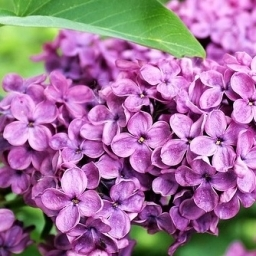

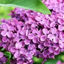

Check if low quality is low quality when upscaled...


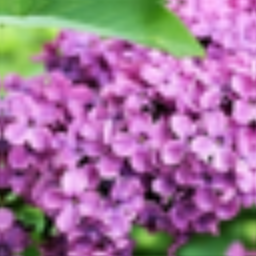

Data Type: uint8
Min: 0.000, Max: 255.000
Min: 0.000, Max: 1.000
Data Type: uint8
Min: 0.000, Max: 255.000
Min: 0.000, Max: 1.000


In [26]:
# Check if downsampling works
print("Checking downsampling of image | ", image_num)

display(array_to_img(train_hr[image_num]))
display(array_to_img(train_lr[image_num]))

lr_upscale = resize(train_lr[image_num],
                           [train_lr[image_num].shape[0]*4,
                            train_lr[image_num].shape[1]*4])
print("Check if low quality is low quality when upscaled...")
display(array_to_img(lr_upscale))

pixels = asarray((train_hr[image_num]))
# confirm pixel range is 0-255
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
# convert from integers to floats
pixels = pixels.astype('float32')
# normalize to the range 0-1
pixels /= 255.0
# confirm the normalization
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

pixels = asarray((train_lr[image_num]))
# confirm pixel range is 0-255
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
# convert from integers to floats
pixels = pixels.astype('float32')
# normalize to the range 0-1
pixels /= 255.0
# confirm the normalization
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

#### Normalization of image arrays!

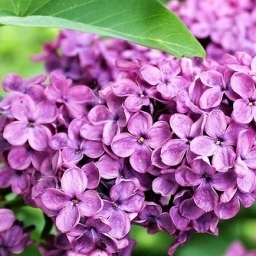

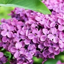

Check if low quality is low quality when upscaled...


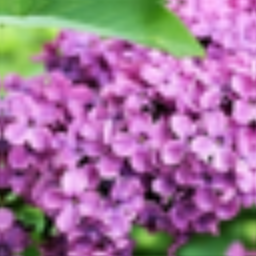

(40, 256, 256, 3)


In [27]:
train_hr = hr_normal(train_hr)
train_lr = hr_normal(train_lr)

test_hr = hr_normal(test_hr)
test_lr = hr_normal(test_lr)

display(array_to_img(train_hr[image_num]))
display(array_to_img(train_lr[image_num]))

lr_upscale = resize(train_lr[image_num],
                           [train_lr[image_num].shape[0]*4,
                            train_lr[image_num].shape[1]*4])
print("Check if low quality is low quality when upscaled...")
display(array_to_img(lr_upscale))
print(train_hr.shape)

In [28]:
pixels = asarray((train_hr[image_num]))
# confirm pixel range is 0-255
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
# convert from integers to floats
pixels = pixels.astype('float32')
# normalize to the range 0-1
pixels /= 255.0
# confirm the normalization
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

pixels = asarray((train_lr[image_num]))
# confirm pixel range is 0-255
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
# convert from integers to floats
pixels = pixels.astype('float32')
# normalize to the range 0-1
pixels /= 255.0
# confirm the normalization
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

Data Type: float32
Min: -1.000, Max: 1.000
Min: -0.004, Max: 0.004
Data Type: float32
Min: -1.000, Max: 1.000
Min: -0.004, Max: 0.004


In [29]:
import matplotlib.pyplot as plt
def plot_generated_images(epoch,gen, examples=3 , dim=(1, 3), figsize=(15, 5)):
    for j in range(0,8):
        rand_nums = np.random.randint(0, test_hr.shape[0], size=examples)
        image_batch_hr = hr_denormal(test_hr[rand_nums])
        image_batch_lr = test_lr[rand_nums]
        gen_img = gen.predict(image_batch_lr)
        generated_image = hr_denormal(gen_img)
        image_batch_lr = hr_denormal(image_batch_lr)

#         print(image_batch_lr.shape)
#         print(generated_image.shape)
#         print(image_batch_hr.shape)

        #generated_image = deprocess_HR(generator.predict(image_batch_lr))

        plt.figure(figsize=figsize)

        plt.subplot(dim[0], dim[1], 1)
        plt.imshow(image_batch_lr[1], interpolation='nearest')
        plt.axis('off')

        plt.subplot(dim[0], dim[1], 2)
        plt.imshow(generated_image[1], interpolation='nearest')
        plt.axis('off')

        plt.subplot(dim[0], dim[1], 3)
        plt.imshow(image_batch_hr[1], interpolation='nearest')
        plt.axis('off')

        plt.tight_layout()
        plt.savefig(config.TRAIN.output_today_now +'/%dimages_LSH_%dresblock_epoch%d_%d.png' % (config.TRAIN.imageNum, config.TRAIN.residual, epoch,j))
    


#### Defining the training method where the GAN gets completely trained, to begin with test with 2 epochs

(40, 64, 64, 3)
(64, 64, 3)
This is the model summary for the Generator: 
Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_168 (InputLayer)          [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 64, 64, 64)   15616       input_168[0][0]                  
__________________________________________________________________________________________________
p_re_lu_9 (PReLU)               (None, 64, 64, 64)   64          conv2d_40[0][0]                  
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 64, 64, 64)   36928       p_re_lu_9[0][0]                  
________________

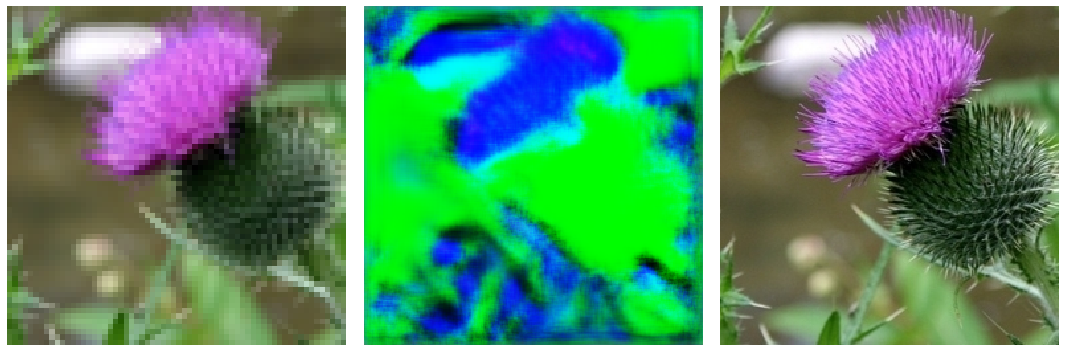

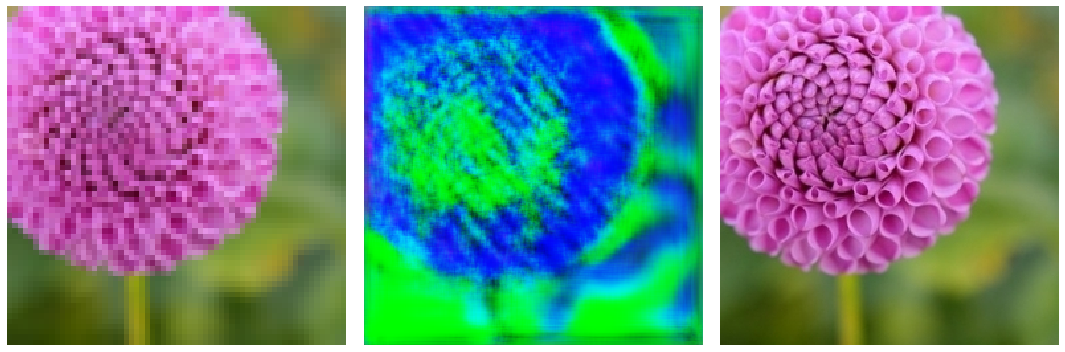

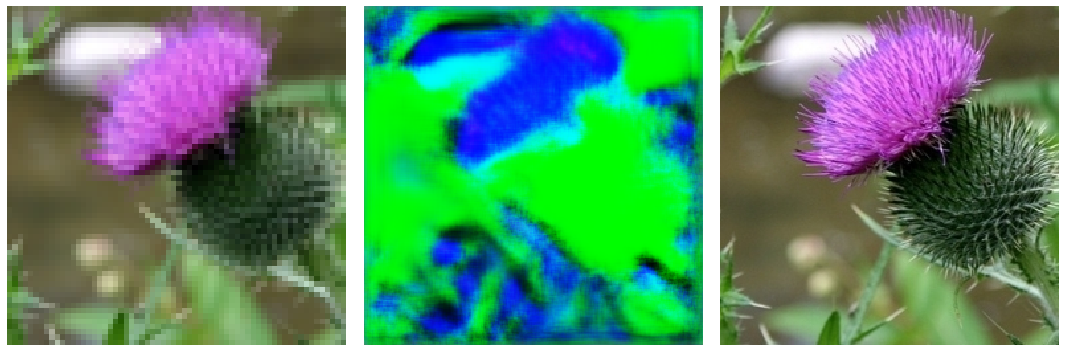

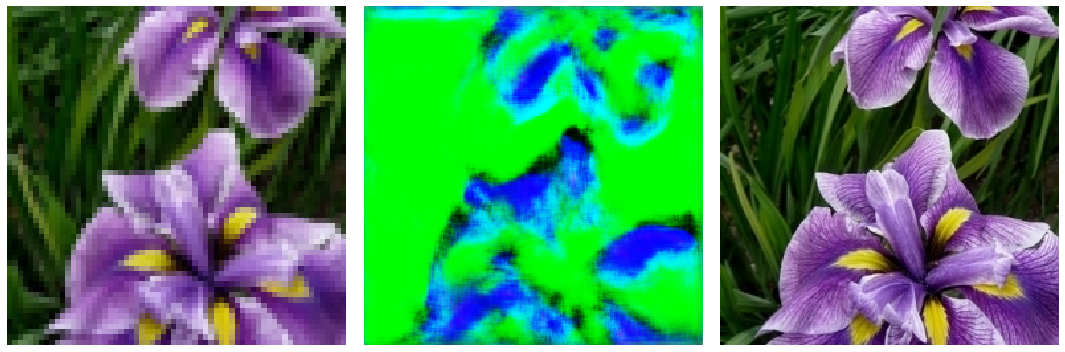

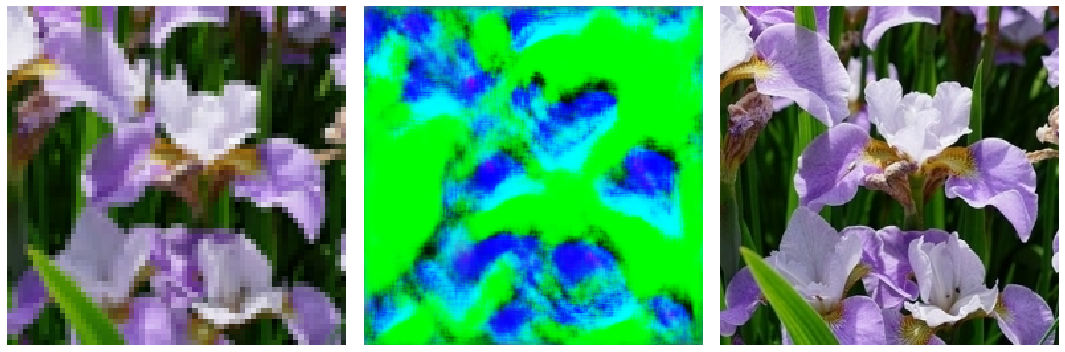

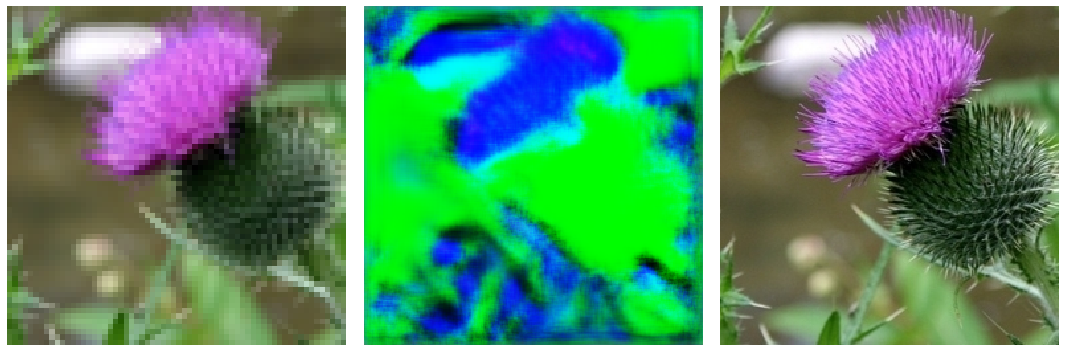

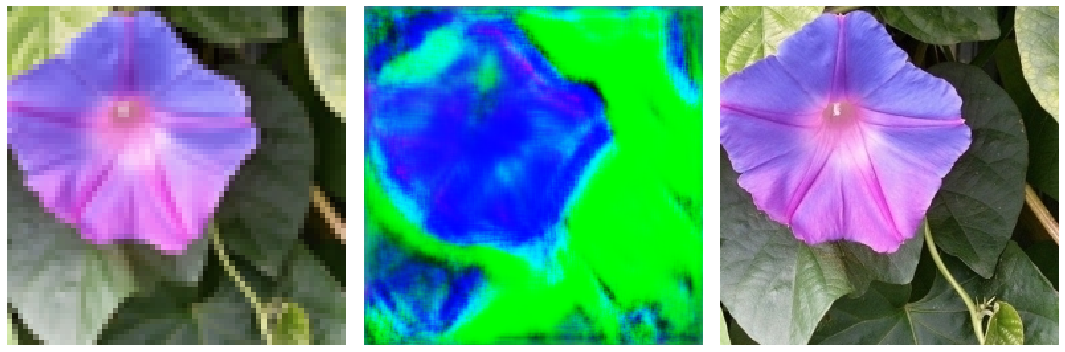

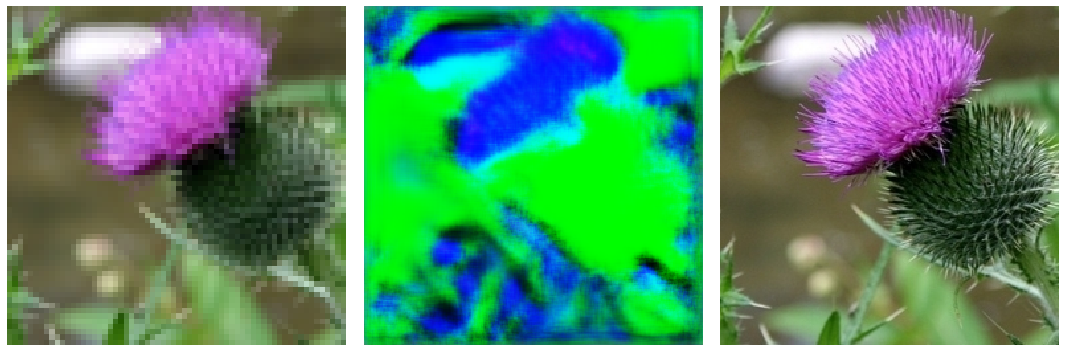

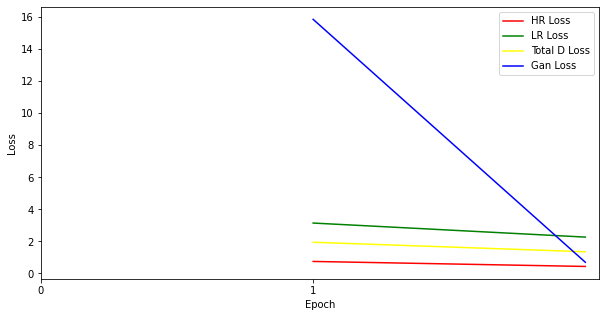

In [36]:
tf.config.run_functions_eagerly(True)
config.TRAIN.csvFileString = config.TRAIN.output_today_now + '/loss_outputs' + str(config.TRAIN.epochs) + 'epochs' + str(config.TRAIN.residual) + 'res' + str(config.TRAIN.imageNum) 
def train(batch_size=config.TRAIN.batch_size):
    downsample = config.TRAIN.downscale
    img_in_batches = int(train_hr.shape[0] / config.TRAIN.batch_size)
    # Image shapes all have the same dimensions but some are landscape and some are portrait
    lr_img_shape = (config.TRAIN.image_shape[0]//downsample, config.TRAIN.image_shape[1]//downsample, config.TRAIN.image_shape[2])
    print(train_lr.shape)
    print(lr_img_shape)
    adam_optimizer = Adam(learning_rate=config.TRAIN.lr_init, beta_1=config.TRAIN.beta1, beta_2=config.TRAIN.beta2, epsilon=config.TRAIN.epsilon)

    # Generator network
    g = GenNet(lr_img_shape)
    g.compile(loss=vgg_loss, optimizer=adam_optimizer, metrics = 'accuracy')
#     g.compile(loss="mse", optimizer=adam_optimizer, metrics = 'accuracy')

    # Discriminator network
    d = DisNet(config.TRAIN.image_shape)
    d.compile(loss="binary_crossentropy", optimizer=adam_optimizer, metrics = 'accuracy')
#     d.compile(loss="mse", optimizer=adam_optimizer, metrics = 'accuracy')

    generative_adversarial_network = make_gan(d, lr_img_shape, g, adam_optimizer)
    
    highResLoss = []
    lowResLoss = []
    GanLoss = []
    totalLoss = []
    epoch = []
    textString = []

    for i in range(1, config.TRAIN.epochs):
        print('='*10, 'Epoch %d' % i, '='*10)
        # Underscore indicates loop variable isn't used
        for _ in range(img_in_batches):

            random_batch = nprand.randint(0, train_hr.shape[0],size=config.TRAIN.batch_size)
            hr_batch = train_hr[random_batch]
            lr_batch = train_lr[random_batch] 
            sr_batch = g.predict(lr_batch)

            real_data = np.ones(config.TRAIN.batch_size) - nprand.random_sample(config.TRAIN.batch_size)*0.2
            fake_data = nprand.random_sample(config.TRAIN.batch_size)*0.2

            d.trainable = True
            # https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_on_batch
            ## train_on_batch(x, y=None, sample_weight=None, class_weight=None, reset_metrics=True,return_dict=False)
            ## x is input data, y is target data, sample_weight to apply to model's loss per sample, optional class_weight mapping, reset_metrics when true resets metrics for this batch, return_dict loss and metric returned as dict
            ### Returns: Scalar training loss (if the model has a single output and no metrics) or 
            ### list of scalars (if the model has multiple outputs and/or metrics). The attribute model.metrics_names will give you the display labels for the scalar outputs.
             # ----------------------
            #  Train Discriminator
            # ----------------------
            discriminator_real_data_loss = d.train_on_batch(x = hr_batch, y = real_data)
            discriminator_fake_data_loss = d.train_on_batch(sr_batch, fake_data)
            total_discriminator_content_loss = 0.5 * np.add(discriminator_real_data_loss, discriminator_fake_data_loss)


    #             random_batch = nprand.randint(0, train_hr.shape[0],size=config.TRAIN.batch_size )
    #             hr_batch = train_hr[random_batch]
    #             lr_batch = train_lr[random_batch] 


            gan_data = np.ones(config.TRAIN.batch_size) - nprand.random_sample(config.TRAIN.batch_size)*0.2
            d.trainable = False
            gan_train_output = [hr_batch, gan_data]
            
            
            #print("length of x", len(gan_data))
            #print("Input data for gan_loss = ")
            #print(" with shape: ", lr_batch.shape)
            #print("Target data for gan_loss = ")
            #print(hr_batch.shape, " and gan_data which is massive with shape: ", gan_data.shape)
            #print("LR image batch: ", type(lr_batch), " with shape: ", lr_batch.shape)
            #print("Gan train output: ", type(gan_train_output))
            #print("HR image batch: ", type(hr_batch), " with shape: ", hr_batch.shape)
            #print("Gan data: ", type(gan_data), " with shape: ", gan_data.shape)
            
            gan_loss = generative_adversarial_network.train_on_batch(x = lr_batch, y = gan_train_output)
#             gan_loss = generative_adversarial_network.train_on_batch(x = lr_batch, y = gan_data)
    #             print(np.matmul(hr_batch,gan_data))
    #             print("Gan_loss should look like = ")
    #             print(lr_batch, [hr_batch, gan_data])

        print("Loss for High Resolution, Loss for Low Resolution, Total Loss, Loss for the GAN, epoch")
        print(discriminator_real_data_loss, discriminator_fake_data_loss, total_discriminator_content_loss, gan_loss, i)

        if i == 1 or i % 3 == 0:
            plot_generated_images(i, g)

        if i % 10 == 0:
            g.save(config.TRAIN.output_today_now +'/generator%d.png' % i)
            d.save(config.TRAIN.output_today_now +'/discriminator%d.png' % i)
            generative_adversarial_network.save(config.TRAIN.output_today_now + '/gan%d' % i)
        
        ### Now deal with the data, save so can be plotted graphically
        highResLoss.append(discriminator_real_data_loss[0])
        lowResLoss.append(discriminator_fake_data_loss[0])
        GanLoss.append(gan_loss[2])
        totalLoss.append(total_discriminator_content_loss[0])
        epoch.append(i)
        wholeString = (## Epoch
            i 
            ## HR Loss
            , discriminator_real_data_loss[0] 
            ## LR Loss
            , discriminator_fake_data_loss[0] 
            ## Total Loss, real + fake * 0.5
            , total_discriminator_content_loss[0] 
            ## Gan losses
            , '[' 
            , gan_loss[0] 
            , gan_loss[1] 
            , gan_loss[2] 
            , ']')
        textString.append(wholeString)
        
    print(highResLoss)
    print(lowResLoss)
    print(GanLoss)
    print(textString)
    plt.figure(figsize=[10,5])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(epoch, highResLoss, label = 'HR Loss', color = 'red')
    plt.plot(epoch, lowResLoss, label = 'LR Loss', color = 'green')
    plt.plot(epoch, totalLoss, label = 'Total D Loss', color = 'yellow')
    plt.plot(epoch, GanLoss, label = 'Gan Loss', color = 'blue')
    plt.xticks(range(0, len(epoch)))
    plt.legend()
    plt.savefig('loss_graph_%dimages' % (config.TRAIN.imageNum))
    plt.show()
    
    ## Also save all of these numeric values to a csv file
    with open((config.TRAIN.csvFileString + 'images.csv'), 'w') as f:
        f.write("Epoch, Loss for High Resolution, Loss for Low Resolution, Total Loss, Loss for the GAN\n")
        for k in range(len(textString)):
            f.write(str(textString[k]))
            f.write('\n')
        f.close()
    
train(config.TRAIN.batch_size)

In [31]:
from keras.applications.vgg19 import VGG19 as VGG
class DIFFGAN():
    def __init__(self):
        print("init called")
        self.channels = 3
        self.height = config.TRAIN.image_shape[0]
        self.width = config.TRAIN.image_shape[1]
        self.downsample = config.TRAIN.downscale
        self.lr_shape = (self.height//self.downsample, self.width//self.downsample, self.channels)
        self.hr_shape = (self.height,self.width,self.channels)
#         self.hr_shape = (224,224,3)
        
        # Res blocks in generator
        self.res_blocks = 16
        
#         adam_optimizer = Adam(learning_rate=config.TRAIN.lr_init, beta_1=config.TRAIN.beta1, beta_2=config.TRAIN.beta2, epsilon=1e-08)
        adam_optimizer = Adam(0.0002, 0.5)
        
        # Use pretrained VGG to extract features from high res and super res and minimize mse between
        self.vgg = self.build_vgg()
        self.vgg.trainable = False
        self.vgg.compile(loss='mse',
                        optimizer=adam_optimizer,
                        metrics=['accuracy'])
        
        high_res_patch = int(self.hr_shape[0] / 2**4)
        self.patch_for_dis = (high_res_patch, high_res_patch, 3)
        
        # build discrimin
        self.discriminator = DisNet(self.hr_shape)
        self.discriminator.compile(loss='mse',
                                  optimizer=adam_optimizer,
                                    metrics=['accuracy'])
        
        # build gen
        self.generator = GenNet(self.lr_shape)
        
        hr_img = Input(shape=self.hr_shape)
        lr_img = Input(shape=self.lr_shape)
        
        # Generate super res from low res
        sr_img = self.generator(lr_img)
        
        # Extract features of sr
        fake_data = self.vgg(sr_img)
        
        # Combine for gan, only train generator
        self.discriminator.trainable = False
        
        # Use Dis to determine if gen image is real or fake
        valid = self.discriminator(sr_img)
        
        self.combined = Model([lr_img, hr_img], [valid, fake_data])
        self.combined.compile(loss=['binary_crossentropy', 'mse'],
                             loss_weights=[config.TRAIN.lr_init, 1],
                             optimizer=adam_optimizer)
#         def vgg_loss(y_true, y_pred):
#     vgg19 = VGG19(include_top=False, weights="imagenet", input_shape=config.TRAIN.image_shape)
#     vgg19.trainable = False
#     vgg19_outputs = vgg19.get_layer('block5_conv4').output
#     for layer in vgg19.layers:
#         layer.trainable = False
#     loss_model = Model(inputs=vgg19.input, outputs=vgg19_outputs)
#     loss_model.trainable = False
#     return K.mean(K.square(loss_model(y_true) - loss_model(y_pred)))
        
    def build_vgg(self):
        """
        Builds a pre-trained VGG19 model that outputs image features extracted at the
        third block of the model
        """
#         vgg = VGG(weights="imagenet")
#         # Set outputs to outputs of last conv. layer in block 3
#         # See architecture at: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
#         vgg.outputs = [vgg.layers[9].output]
# #         vgg.outputs = vgg19.get_layer('block5_conv4').output

#         img = Input(shape=self.hr_shape)
#         print(img, " \n is the image item")

#         # Extract image features
#         img_features = vgg(img)
#         print("\n",img_features)
        vgg19 = VGG19(include_top=False, weights="imagenet", input_shape=config.TRAIN.image_shape)
        vgg19.trainable = False
        vgg19_outputs = vgg19.get_layer('block5_conv4').output
        for layer in vgg19.layers:
            layer.trainable = False
        loss_model = Model(inputs=vgg19.input, outputs=vgg19_outputs)


        return loss_model
    
    def train(self, epochs, batch_size=1, sample_interval=50):                
        for i in range(1, config.TRAIN.epochs):
            print('='*10, 'Epoch %d' % i, '='*10)
            # Underscore indicates loop variable isn't used

            random_batch = nprand.randint(0, train_hr.shape[0],size=1)
            hr_batch = train_hr[random_batch]
            print(hr_batch.shape, "hr_shape")
            lr_batch = train_lr[random_batch] 
            sr_batch = self.generator.predict(lr_batch)

            # ----------------------
            #  Train Discriminator
            # ----------------------
            valid = np.ones((batch_size,) + self.patch_for_dis)
            print(valid.shape, " valid")
            fake = np.zeros((batch_size,) + self.patch_for_dis)

            # Train the discriminators (original images = real / generated = Fake)
#             d.trainable = True
            d_loss_real = self.discriminator.train_on_batch(x=hr_batch, y=valid)
            d_loss_fake = self.discriminator.train_on_batch(x=sr_batch, y=fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ------------------
            #  Train Generator
            # ------------------
            hr_batch = train_hr[random_batch]
            lr_batch = train_lr[random_batch] 
            # The generators want the discriminators to label the generated images as real
            valid = np.ones((batch_size,) + self.patch_for_dis)

            # Extract ground truth image features using pre-trained VGG19 model
            image_features = self.vgg.predict(hr_batch)


            # Train the generators
            g_loss = self.combined.train_on_batch([lr_batch, hr_batch], [valid, image_features])

            print("Loss for High Resolution, Loss for Low Resolution, Loss for the GAN, epoch")
            print(d_loss_real, d_loss_fake, g_loss, i)

            if i == 1 or i % 3 == 0:
                plot_generated_images_diff(i, self.generator)

            if i % 100 == 0:
                g.save(config.TRAIN.output_today_now +'/generator%d.png' % i)
                d.save(config.TRAIN.output_today_now +'/discriminator%d.png' % i)
                generative_adversarial_network.save(config.TRAIN.output_today_now + '/gan%d' % i)